# Covariates Assisted Spectral Embedding and Clustering

This demos shows how to use the Covariates Assisted Spectral Embed (CASC) class.

In [1]:
import numpy as np
np.random.seed(8889)
from sklearn.metrics import adjusted_rand_score as ARI
from graspologic.embed.casc import CovariateAssistedSpectralEmbed
from graspologic.simulations import sbm
from graspologic.plot import heatmap, pairplot

%matplotlib inline

## Using CASC on simple stochastic block model (SBM) graphs 
CASC is a method for stochastic graph embedding and clustering.Compared with traditional Laplacian Embedding, CASC utilize information from a bernoulli covariate matrix, these binary covariates are mostly obtained from regression. Here we uses a random sampling from bernoulli distributions with given probability to simulate these covariates. CASC adopts a SVD decomposition on a weighted sum of Laplacian Matrix and Covariate Matrix instead of Laplacian Matrix only in traditional spectral embedding.

The weighted sum can be noted as follows,where $h$ is a tuning parameter obtained by optimizing within-cluster sum of squares.$L$ is the regularized Laplacian and $X$ is the Covariate Matrix.

For assortative graphs:
$L'=L+h*XX^T$

For non-assortative graphs:
$L'=LL^T+h*XX^T$

Gerenally, a graph is assortative if nodes within the same cluster are more likely to share an edge than nodes in two different clusters, otherwise it is  non-assortative.

Here we generate an assortative Adjacency Matrix using SBM simulation composed of 3 blocks and 100 nodes in each block.And an assortative Covariate Matrix with 3 covariates.

<AxesSubplot:title={'center':'2-block SBM (undirected)'}>

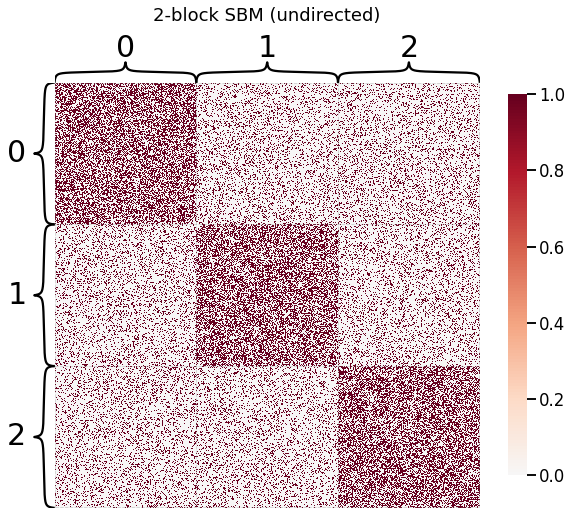

In [2]:
n_verts = 1000
labels_sbm = n_verts * [0] + n_verts * [1] + n_verts * [2]
P=np.array([[0.5,0.2,0.2],[0.2,0.5,0.2],[0.2,0.2,0.5]])
undirected_sbm = sbm(3 * [n_verts], P)
heatmap(undirected_sbm, title='2-block SBM (undirected)', inner_hier_labels=labels_sbm)



Here we define a function to generate bernoulli covariate matrix.

In [3]:
def GraphCovaritesSimulater(covProb,labels,agreement):
    '''generate bernoulli covariate matrix with  probability matrix and labels
    agreement=1'''
   
    base=np.eye(max(labels)+1)
    membership=np.zeros([len(labels),covProb.shape[1]])
    n_misassign=0
    for i in range (0,len(labels)):
        assignRV=bool(np.random.binomial(1,agreement))
        if assignRV:
            membership[i,:]=base[labels[i],:]
        else:
            membership[i,:]=base[(labels[i]+1)%(max(labels)+1),:]
            n_misassign=n_misassign+1
    agreement_=1-n_misassign/(len(labels))
    probMat=np.dot(membership,covProb)
    covMat=np.zeros(probMat.shape)
    for i in range(0,covMat.shape[0]):
        for j in range(0,covMat.shape [1]):
            covMat[i,j]=np.random.binomial(1,probMat[i,j])
 
 
    return covMat

Then we generate a covariate matrix with covariate probability matrix 
$$
P_{cov}=\left[ \begin{matrix}
	0.8&		0.2&		0.2\\
	0.2&		0.8&		0.2\\
	0.2&		0.2&		0.8\\
\end{matrix} \right] 
$$


In [4]:
cov_prob=np.array([[0.8,0.2,0.2],[0.2,0.8,0.2],[0.2,0.2,0.8]])
Covariates=GraphCovaritesSimulater(cov_prob,labels_sbm,1)


We can use the CovariateAssistedSpectralEmbed class to embed the adjacency matrix and the covariate matrix as follows. 

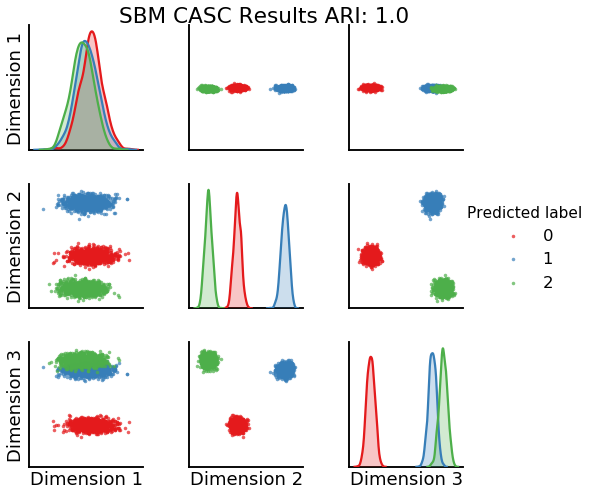

In [5]:
casc = CovariateAssistedSpectralEmbed(form='R-DAD',regularizer=1,n_components=3,assortative=True,cca=True,check_lcc=False)
clusters,embedding,h_opt,inertia = casc.fit_predict(undirected_sbm,Covariates) 
ari=ARI(clusters,labels_sbm)
pairplot(embedding,labels=clusters, legend_name='Predicted label',title='SBM CASC Results ARI: {}'.format(str(ari)[:5]))

